# Findings

- Though this is not proven to be converged, we see here that there are differences in the additive approach, just only visible on much tighter axes. 
- For small $\omega_0$ (though $\approx \eta$), the Redfield approach seems to predict very little effect on the overall populations and coherences
- The Additive collective coordinate approach leads to greater excitation of the bright state than the non-additive. Non-additive has more pronounced redistribution among GS and DS.
- Amazingly, the additive and non-additive predict exactly the same exciton coherence. This is baffling and will need to be examined a lot further.
- One issue is that we are dealing with system splittings which are an order of magnitude larger than this, but the same incoherent excitation temperature. This also goes to couplings of about 5% of the splitting, whereas my other plots only go to about 1% of the splitting.
- I also use a $k_{B_{ph}} \approx 2 \omega_0$, which is quite a bit larger than in the results with optical parameters, where $k_{B_{ph}} \approx \omega_0$ and these plots have terrible resolution.
- In this regime, the weak-coupling theory is totally invalid
- We would expect the additive theory to break down in regimes where the phonon frequency is low, as this is where the displacements are larger. 
- Additivity works well at low temperatures, the change observables wrt $\alpha$ is far more sensitive than the due to changes in additivity. Even weak-coupling theory works quite well at low-T (though not for very low frequencies).

# Explanations

The low temperature means that the population stays in the lower eigenstates in the manifold and there is relatively little upward transition. This causes the phonon transition rates to dominate over the optical transition rates. When $T_{ph}$ is larger, the population stays higher in the manifold and that nature of the optical transitions is exhibited more.

In [66]:
Occupation(11000., 6000.)

0.07701986980267503

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import heatmap_setup as hm
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [2]:
def get_dynamics_data(PARAMS, data_num, threshold=0., tf=2.):
    #print PARAMS['H_sub'].eigenstates()
    ti = time.time()
    
    
    H, L, L_add, PARAMS = get_H_and_L(PARAMS, silent=False, threshold=threshold)
    
    H_wc, L_ns, L_s = get_H_and_L_wc(H[0], PARAMS, shift=True)
    
    evals, evecs = exciton_states(PARAMS, shift=True)
    dark, bright = evecs[0]*evecs[0].dag(), evecs[1]*evecs[1].dag()
    eig_x = (evecs[0]*evecs[1].dag() + evecs[1]*evecs[0].dag())*0.5
    site_x = (site_coherence+site_coherence.dag())
    site_y = 1j*(site_coherence-site_coherence.dag())
    ops = make_expectation_operators(PARAMS)
    eig_y = 1j*(evecs[0]*evecs[1].dag() - evecs[1]*evecs[0].dag())*0.5
    
    # 1 is weak coupling, room temperature, low freq
    timelist = np.linspace(0, tf, 1000)

    init_sys = XO_proj
    v0 = tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], Occupation(PARAMS['w0_1'], PARAMS['T_1'])))
    e_ops=[ops['OO'], ops['dark'], ops['bright'], ops['XO'], ops['OX'], ops['sigma_x'], ops['eig_x'], ops['sigma_y'], ops['eig_y']]
    e_ops_wc=[OO_proj, dark, bright, XO_proj, OX_proj, site_x, eig_x, site_y, eig_y]
    
    if PARAMS['sys_dim'] ==4:
        e_ops+=ops['XX']
        e_ops_wc+= XX_proj
    print("Liouvillians took {} seconds".format(time.time()-ti))
    
    ss_wcs = steadystate(H_wc, [L_s])
    ss_wc = steadystate(H_wc, [L_ns])
    ss_add = steadystate(H[1], [L_add])
    ss_nonadd = steadystate(H[1], [L])
    print((ss_wcs*OO_proj).tr().real, (ss_wc*OO_proj).tr().real, 
          (ss_add*ops['OO']).tr().real, (ss_nonadd*ops['OO']).tr().real)
    print((ss_wcs*eig_x).tr().real, (ss_wc*eig_x).tr().real, 
          (ss_add*ops['eig_x']).tr().real, (ss_nonadd*ops['eig_x']).tr().real)
    
    options = qt.Options(nsteps=20000)
    dat_wcs = qt.mesolve(H_wc, init_sys, timelist, c_ops=[L_s], 
                      e_ops=e_ops_wc, options=options) # weak coupling
    dat_wc = qt.mesolve(H_wc, init_sys, timelist, c_ops=[L_ns], 
                      e_ops=e_ops_wc, options=options) # weak coupling
    #dat_add = qt.mesolve(H[1], v0, timelist, c_ops=[L_add], 
    #                  e_ops=e_ops, progress_bar=True, options=options)
    dat_nonadd = qt.mesolve(H[1], v0, timelist, c_ops=[L], 
                      e_ops=e_ops, progress_bar=True, options=options)
    
    
    try:
        data_dict = {}
        filename = 'DATA/DYNAMICS_2019/3LS_dynamics_'+str(data_num)
        PARAM_names = [ 'dat_nonadd', 'dat_wcs', 'dat_wc',
                       'PARAMS', 'ss_nonadd', 'ss_add', 'ss_wcs', 'ss_wc','timelist']
        scope = locals() # Lets eval below use local variables, not global
        data_dict.update(dict((name, eval(name, scope)) for name in PARAM_names))
        save_obj(data_dict, filename)
        print( "Filename: "+filename)
    except Exception as e:
        print( "Could not save data because ", e)
    return data_dict


In [11]:
def plot_dynamics(data_dict):
    
    # code goes here to take in and plot dynamics for wc, add and non-add
    tl =data_dict['timelist']
    labels = ['Redfield', 'Non-add.']
    f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(14,8))
    for i, suff in enumerate(['_wc', '_nonadd']):
        alpha=1
        ls='solid'
        if i>0:
            alpha=0.5
            #ls='dotted'
        #GS pop
        ax1.plot(tl, data_dict['dat'+suff].expect[0], label=labels[i], alpha=alpha, ls=ls)
        ax1.set_ylabel(r"GS")
        ax1.set_xlim(tl[0], tl[-1])
        ax1.legend()
        #DS pop
        ax2.plot(tl, data_dict['dat'+suff].expect[1], label=labels[i], alpha=alpha, ls=ls)
        ax2.set_xlim(tl[0], tl[-1])
        ax2.set_ylabel(r"DS")
        ax2.legend()
        
        ax3.plot(tl, data_dict['dat'+suff].expect[2], label=labels[i], alpha=alpha, ls=ls)
        ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax3.set_ylabel(r"BS")
        ax3.set_xlim(tl[0], tl[-1])
        ax3.legend()
        
        ax4.plot(tl, data_dict['dat'+suff].expect[6], label=labels[i], alpha=alpha, ls=ls)
        ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
        ax4.set_ylabel(r"$\Re \expval{|+\langle\!\rangle -|}$")
        ax4.set_xlim(tl[0], tl[-1])
        ax4.legend()
        
def plot_UD_SD(Gamma, alpha, w_0, eps=6000., ax=None, eta=0.):
    Omega = np.linspace(0,eps,10000)
    J_w = np.array([J_underdamped(w, alpha, w_0, Gamma=Gamma) for w in Omega])
    show_im = ax
    if ax is None:
        f, ax = plt.subplots(1,1)
    ax.axvline(eta, color='k', ls='dashed')
    ax.plot(Omega, J_w)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$J(\omega)$")
    if show_im is None:
        plt.show()

# Low $\omega_0$

$\alpha = 1, 10, 50$

In [38]:
1/(0.695*77)

0.01868634962160142

In [39]:
1/(0.695*6000)

0.00023980815347721823

In [44]:
T_ph = 300.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm

T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =5

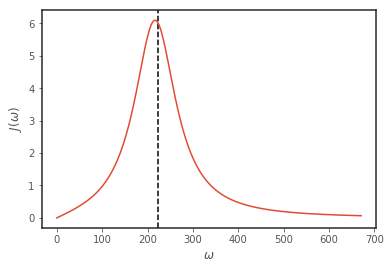

****************************************************************
The operators took 2.947171211242676 and have dimension 78.
Building the RC Liouvillian took 3.372 seconds.
It is 6084by6084. The full basis would be 11664by11664
Full optical Liouvillian took 2.2711710929870605 seconds.
Full optical Liouvillian took 0.716273307800293 seconds.
Chopping reduced the sparsity from 5.259% to 5.259%
Liouvillians took 10.197300910949707 seconds
0.4888979120127451 0.4894396322846956 0.49023707945357065 0.4902253911438136
-0.0003413812999964738 -0.000340864226419324 -0.0003517356545955457 -0.0003517322426358824
10.0%. Run time:   1.78s. Est. time left: 00:00:00:16
20.0%. Run time:   3.40s. Est. time left: 00:00:00:13
30.0%. Run time:   5.04s. Est. time left: 00:00:00:11
40.0%. Run time:   6.66s. Est. time left: 00:00:00:09
50.0%. Run time:   8.63s. Est. time left: 00:00:00:08
60.0%. Run time:  10.59s. Est. time left: 00:00:00:07
70.0%. Run time:  12.77s. Est. time left: 00:00:00:05
80.0%. Run tim

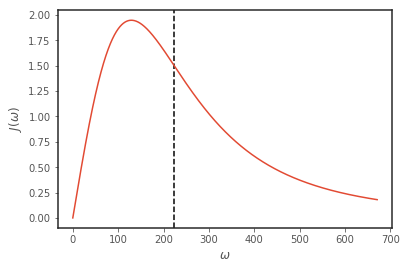

****************************************************************
The operators took 2.8355889320373535 and have dimension 78.
Building the RC Liouvillian took 3.208 seconds.
It is 6084by6084. The full basis would be 11664by11664
Full optical Liouvillian took 2.2501628398895264 seconds.
Full optical Liouvillian took 0.7585208415985107 seconds.
Chopping reduced the sparsity from 5.262% to 5.262%
Liouvillians took 11.222316026687622 seconds
0.48802247761281164 0.48856622926172977 0.49026943089405445 0.4902572995770295
-0.0003267629584666476 -0.00032661678778739267 -0.00035177765807551336 -0.0003517822830997104
10.0%. Run time:   6.94s. Est. time left: 00:00:01:02
20.0%. Run time:  14.49s. Est. time left: 00:00:00:57
30.0%. Run time:  22.31s. Est. time left: 00:00:00:52
40.0%. Run time:  30.70s. Est. time left: 00:00:00:46
50.0%. Run time:  38.99s. Est. time left: 00:00:00:38
60.0%. Run time:  47.59s. Est. time left: 00:00:00:31
70.0%. Run time:  57.26s. Est. time left: 00:00:00:24
80.0%. 

"\nalpha = 10.\nPARAMS = PARAMS_setup(bias=bias, w_2=w_2, \n                              V = V, alpha=alpha,\n                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,\n                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,\n                      silent=True, exc_diff=0)\ndynamics_1b = get_dynamics_data(PARAMS, '1b', threshold=0., tf=4)\n\nalpha = 50.\nN=6\nPARAMS = PARAMS_setup(bias=bias, w_2=w_2, \n                              V = V, alpha=alpha,\n                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,\n                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,\n                      silent=True, exc_diff=0)\ndynamics_1c = get_dynamics_data(PARAMS, '1c', threshold=0., tf=4)"

In [46]:
eta = sqrt(bias**2 + 4*V**2)
alpha = 3.
#wc = 50.
w_0 = eta
Gamma = eta/2

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)


plot_UD_SD(Gamma, alpha, w_0, eps=3*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, '1a', threshold=0., tf=1)

eta = sqrt(bias**2 + 4*V**2)
alpha = 3.
#wc = 50.
w_0 = eta
Gamma = 2*eta

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)


plot_UD_SD(Gamma, alpha, w_0, eps=3*eta, ax=None, eta=eta)
dynamics_1a = get_dynamics_data(PARAMS, '1a', threshold=0., tf=1)
"""
alpha = 10.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_1b = get_dynamics_data(PARAMS, '1b', threshold=0., tf=4)

alpha = 50.
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_1c = get_dynamics_data(PARAMS, '1c', threshold=0., tf=4)"""

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


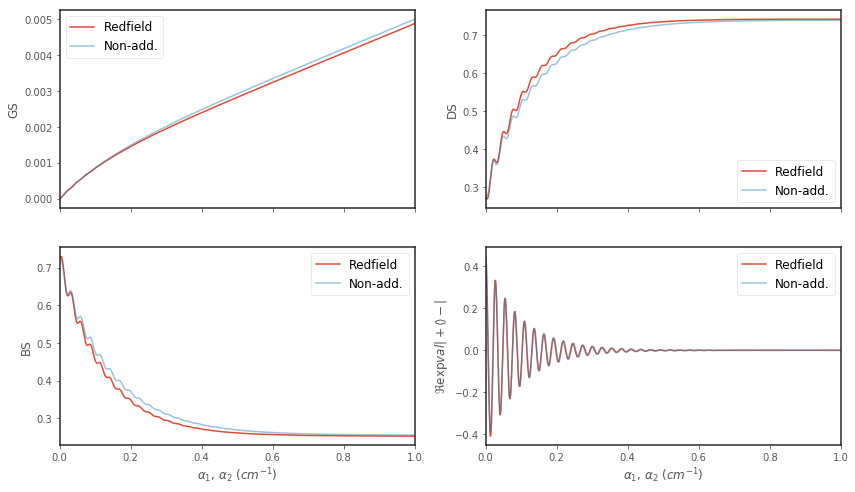

In [47]:
plot_dynamics(dynamics_1a)

In [26]:
dynamics_1a = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_1a")
#dynamics_1b = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_1b")
#dynamics_1c = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_1c")

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


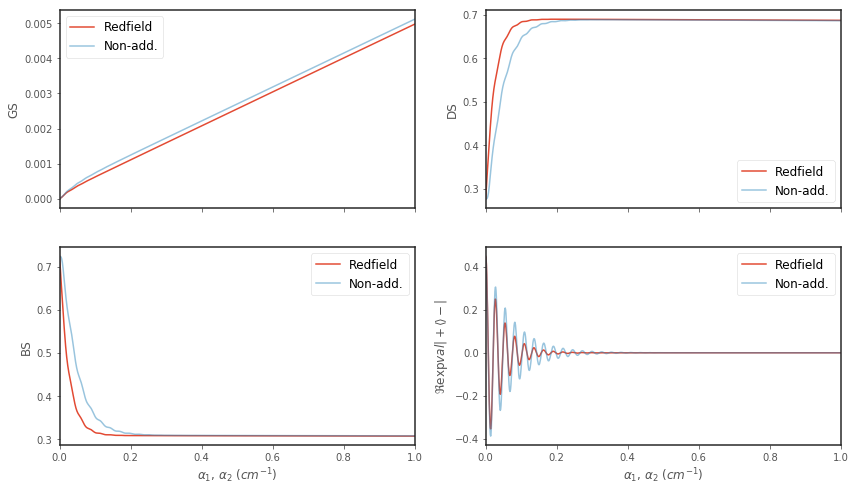

In [43]:
plot_dynamics(dynamics_1a)
#plot_dynamics(dynamics_1b)
#plot_dynamics(dynamics_1c)

# larger $\omega_0$

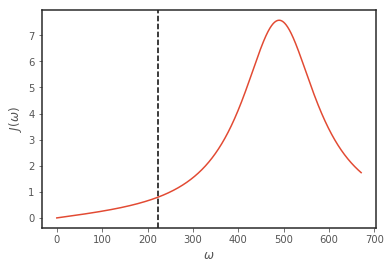

****************************************************************
The operators took 1.6077556610107422 and have dimension 57.
Building the RC Liouvillian took 1.742 seconds.
It is 3249by3249. The full basis would be 5625by5625
Full optical Liouvillian took 1.1777300834655762 seconds.
Full optical Liouvillian took 0.40520405769348145 seconds.
Chopping reduced the sparsity from 7.183% to 7.183%
Liouvillians took 7.5956690311431885 seconds
0.48899436856082007 0.48926936744244237 0.48954939917909074 0.4895422397808765
-0.00011491394890703055 -0.00011465359801474118 -0.00011245420249420298 -0.00011245529792628939
10.0%. Run time:   2.09s. Est. time left: 00:00:00:18
20.0%. Run time:   4.29s. Est. time left: 00:00:00:17
30.0%. Run time:   6.50s. Est. time left: 00:00:00:15
40.0%. Run time:   8.72s. Est. time left: 00:00:00:13
50.0%. Run time:  10.96s. Est. time left: 00:00:00:10
60.0%. Run time:  13.23s. Est. time left: 00:00:00:08
70.0%. Run time:  15.51s. Est. time left: 00:00:00:06
80.0%.

In [45]:
w_0 = 500.
Gamma = 200.
N=5
T_ph = 300.
eta = sqrt(bias**2 + 4*V**2)
plot_UD_SD(Gamma, alpha, w_0, eps=3*eta, ax=None, eta=eta)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2a = get_dynamics_data(PARAMS, '2a', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2b = get_dynamics_data(PARAMS, '2b', threshold=0., tf=1)
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_2c = get_dynamics_data(PARAMS, '2c', threshold=0., tf=0.25)

In [28]:
dynamics_2a = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_2a")
dynamics_2b = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_2b")
dynamics_2c = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_2c")

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


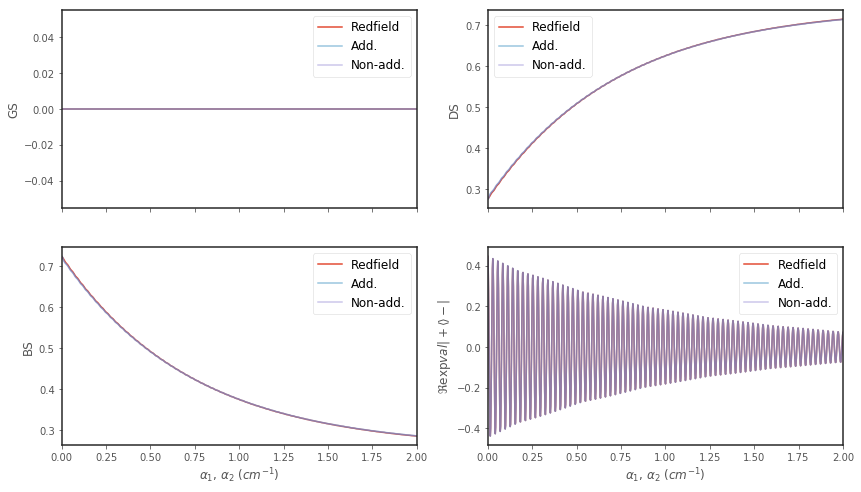

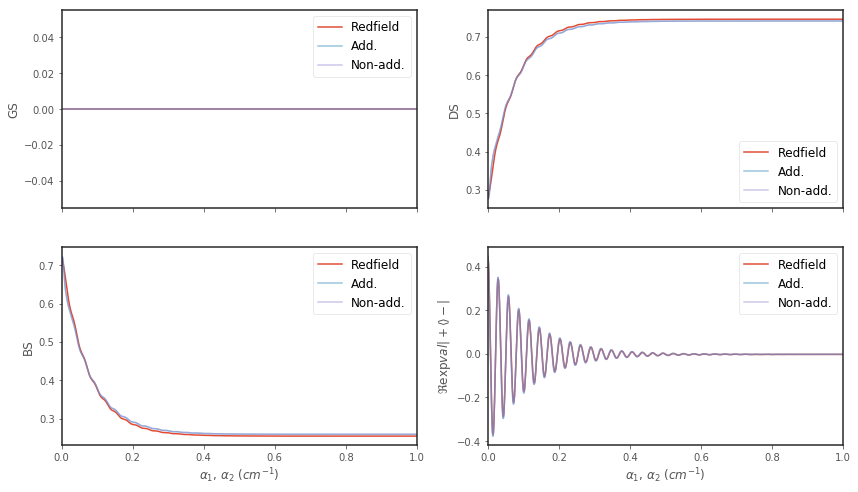

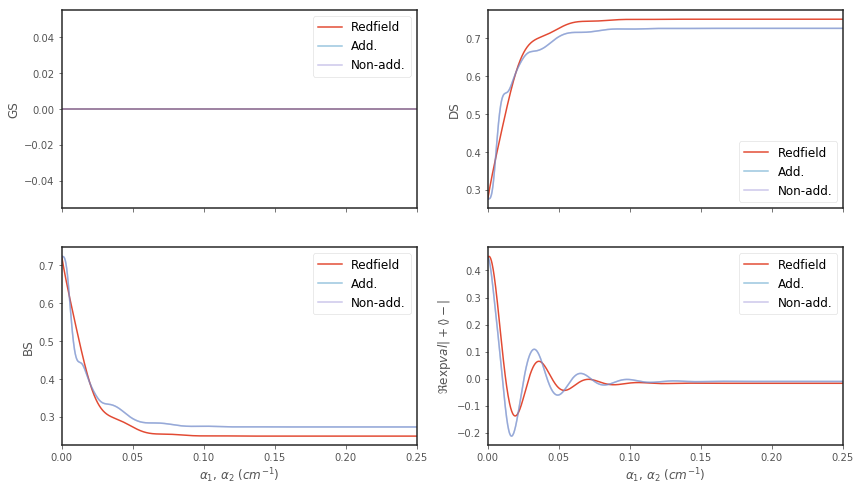

In [29]:
plot_dynamics(dynamics_2a)
plot_dynamics(dynamics_2b)
plot_dynamics(dynamics_2c)

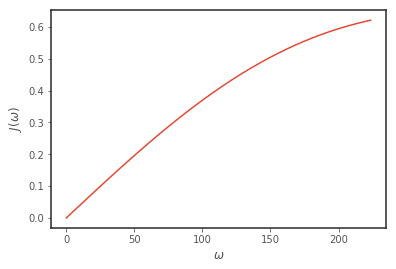

In [44]:
plot_UD_SD(Gamma, alpha, 500., eps=1*sqrt(bias**2 +4*(V**2)), ax=None)

# Low $T_{ph}$

In [15]:
w_0 = 200.
Gamma = 200.
N=5
T_ph = 77.
alpha_EM = 0. #0.01
T_EM=6000.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
PARAMS['alpha_1'] = 0
dynamics_3aa = get_dynamics_data(PARAMS, '3aa', threshold=0., tf=3)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
PARAMS['alpha_1'] = 0
dynamics_3bb = get_dynamics_data(PARAMS, '3bb', threshold=0., tf=2)
N=6
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
PARAMS['alpha_1'] = 0
dynamics_3cc = get_dynamics_data(PARAMS, '3cc', threshold=0., tf=2)

****************************************************************
The operators took 0.8845999240875244 and have dimension 57.
Building the RC Liouvillian took 0.938 seconds.
It is 3249by3249. The full basis would be 5625by5625
Not including optical dissipator
Chopping reduced the sparsity from 1.857% to 1.857%
Liouvillians took 2.2360448837280273 seconds
1.0 1.0 1.0000000000000002 1.0000000000000002
0.0 0.0 0.0 0.0
10.0%. Run time:   0.61s. Est. time left: 00:00:00:05
20.0%. Run time:   1.25s. Est. time left: 00:00:00:05
30.0%. Run time:   1.87s. Est. time left: 00:00:00:04
40.0%. Run time:   2.48s. Est. time left: 00:00:00:03
50.0%. Run time:   3.09s. Est. time left: 00:00:00:03
60.0%. Run time:   3.69s. Est. time left: 00:00:00:02
70.0%. Run time:   4.29s. Est. time left: 00:00:00:01
80.0%. Run time:   4.89s. Est. time left: 00:00:00:01
90.0%. Run time:   5.50s. Est. time left: 00:00:00:00
Total run time:   6.10s
10.0%. Run time:   0.60s. Est. time left: 00:00:00:05
20.0%. Run time: 

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


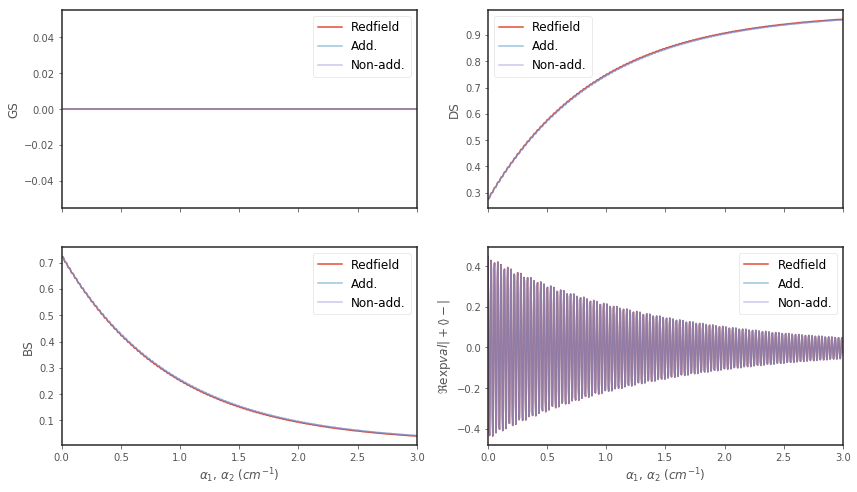

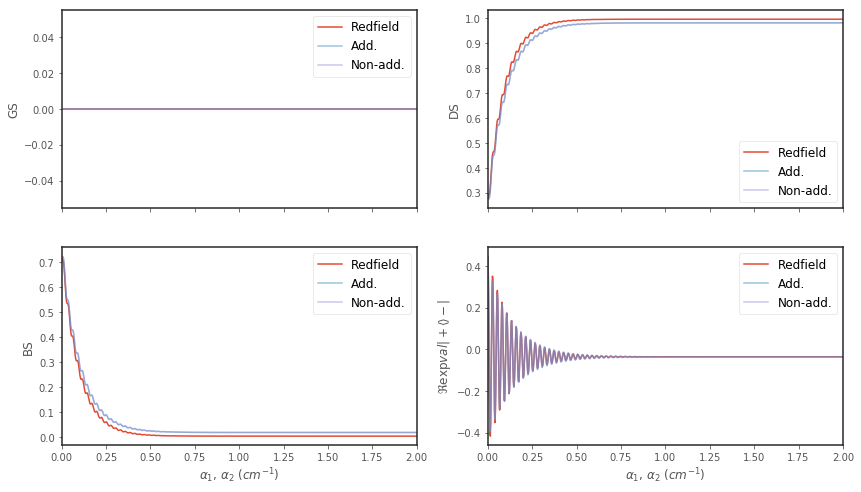

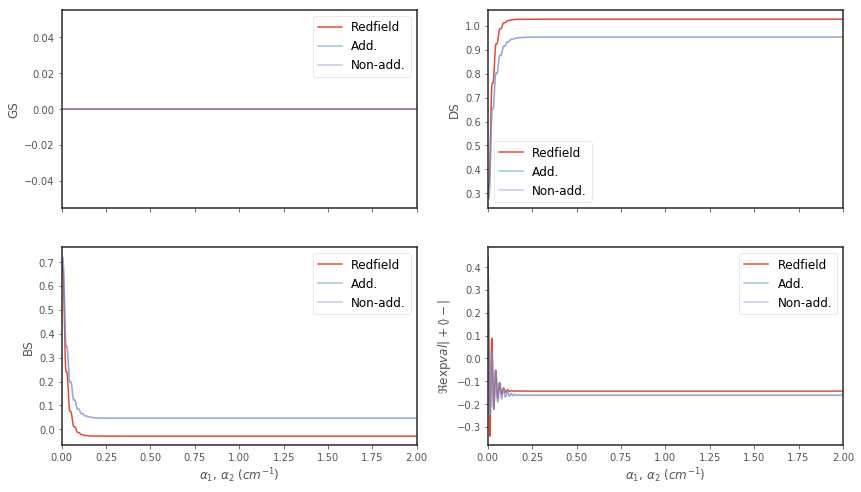

In [16]:
plot_dynamics(dynamics_3aa)
plot_dynamics(dynamics_3bb)
plot_dynamics(dynamics_3cc)

# very high $\omega_0$ (underdamped), but not larger than site energy

In [19]:
w_0 = 5000.
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4a = get_dynamics_data(PARAMS, '4a', threshold=1e-9, tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4b = get_dynamics_data(PARAMS, '4b', threshold=1e-9, tf=1)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_4c = get_dynamics_data(PARAMS, '4c', threshold=1e-9, tf=0.25)

****************************************************************
The operators took 2.0762829780578613 and have dimension 57.
Building the RC Liouvillian took 2.246 seconds.
It is 3249by3249. The full basis would be 5625by5625
Not including optical dissipator
Chopping reduced the sparsity from 5.984% to 4.904%
Liouvillians took 4.9206390380859375 seconds
1.0 1.0 1.0000000007175742 1.0000000007175742
0.0 0.0 2.0113592011533587e-14 2.0113592011533587e-14
10.0%. Run time:  19.82s. Est. time left: 00:00:02:58
20.0%. Run time:  39.99s. Est. time left: 00:00:02:39
30.0%. Run time:  60.51s. Est. time left: 00:00:02:21
40.0%. Run time:  80.78s. Est. time left: 00:00:02:01
50.0%. Run time: 100.71s. Est. time left: 00:00:01:40
60.0%. Run time: 121.08s. Est. time left: 00:00:01:20
70.0%. Run time: 141.20s. Est. time left: 00:00:01:00
80.0%. Run time: 160.80s. Est. time left: 00:00:00:40
90.0%. Run time: 180.94s. Est. time left: 00:00:00:20
Total run time: 200.75s
10.0%. Run time:  19.79s. Est. ti

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


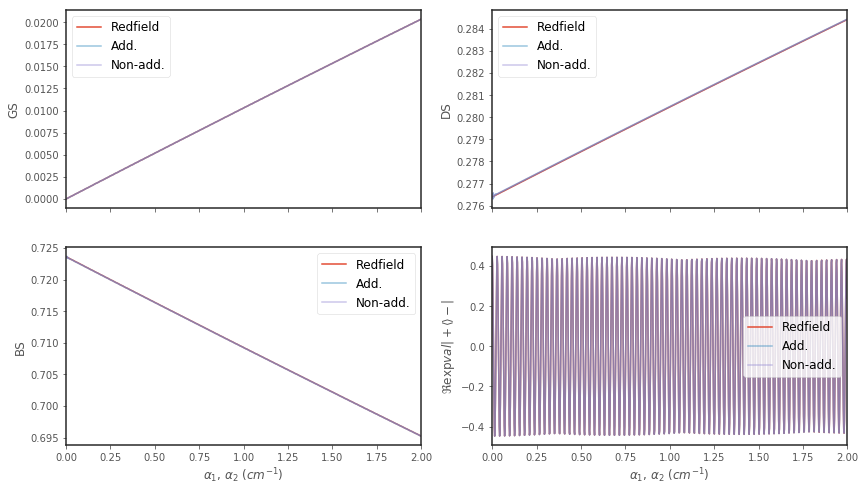

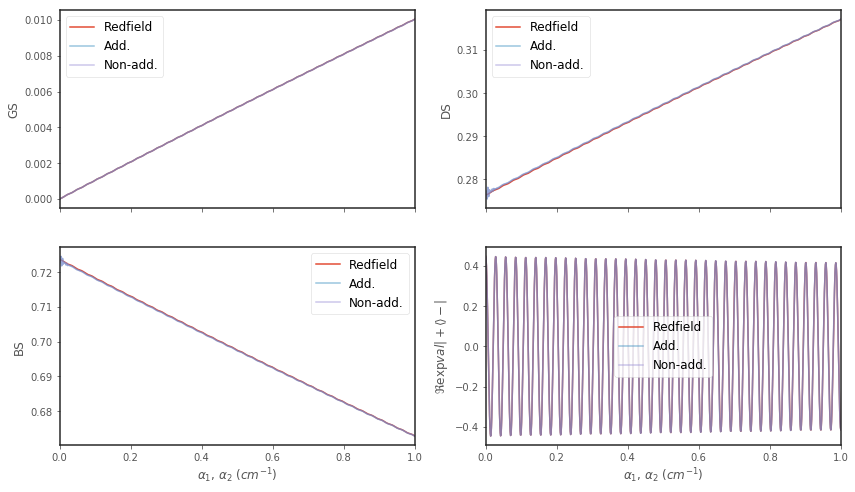

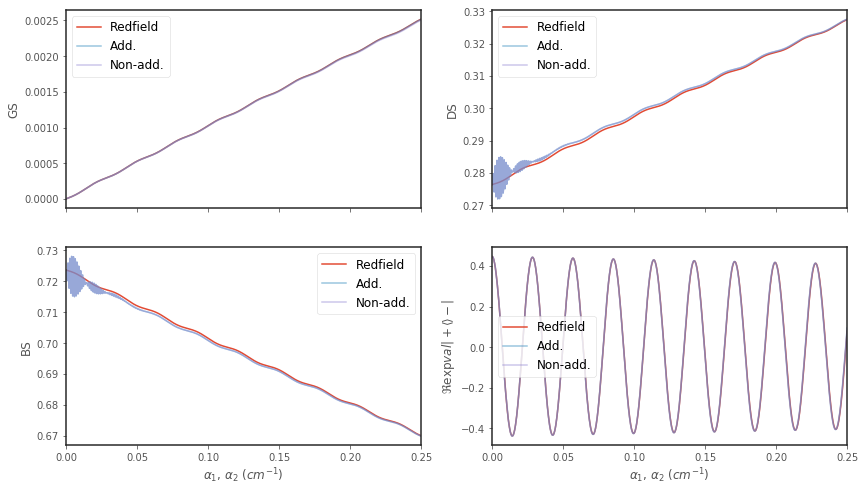

In [59]:
plot_dynamics(dynamics_4a)
plot_dynamics(dynamics_4b)
plot_dynamics(dynamics_4c)

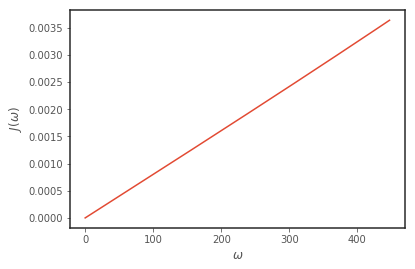

In [22]:
plot_UD_SD(200., 1., 5000., eps=2*sqrt(bias**2 +4*(V**2)), ax=None)

# very high $\omega_0$ (overdamped), but not larger than site energy

In [33]:
w_0 = 2000. # 
Gamma = (w_0**2)/53.
N=3
T_ph = 300.
alpha_EM = 0.001
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5a = get_dynamics_data(PARAMS, '5a', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5b = get_dynamics_data(PARAMS, '5b', threshold=0., tf=1)


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5c = get_dynamics_data(PARAMS, '5c', threshold=0., tf=1.)

****************************************************************
The operators took 0.3537909984588623 and have dimension 24.
Building the RC Liouvillian took 0.369 seconds.
It is 576by576. The full basis would be 729by729
It took  0.354508638381958  seconds to build the Non-secular RWA Liouvillian
It took  0.14738702774047852  seconds to build the Non-secular RWA Liouvillian
Chopping reduced the sparsity from 14.354% to 14.354%
Liouvillians took 15.04849886894226 seconds
0.48748875351722604 0.4875905277059754 0.4892247447966356 0.4892125689120085
-0.0001090445252694 -0.00010913569965179115 -6.16720317691382e-05 -6.167210442677128e-05
10.0%. Run time:  10.31s. Est. time left: 00:00:01:32
20.0%. Run time:  21.83s. Est. time left: 00:00:01:27
30.0%. Run time:  33.49s. Est. time left: 00:00:01:18
40.0%. Run time:  43.97s. Est. time left: 00:00:01:05
50.0%. Run time:  54.22s. Est. time left: 00:00:00:54
60.0%. Run time:  64.44s. Est. time left: 00:00:00:42
70.0%. Run time:  74.77s. Est. ti

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


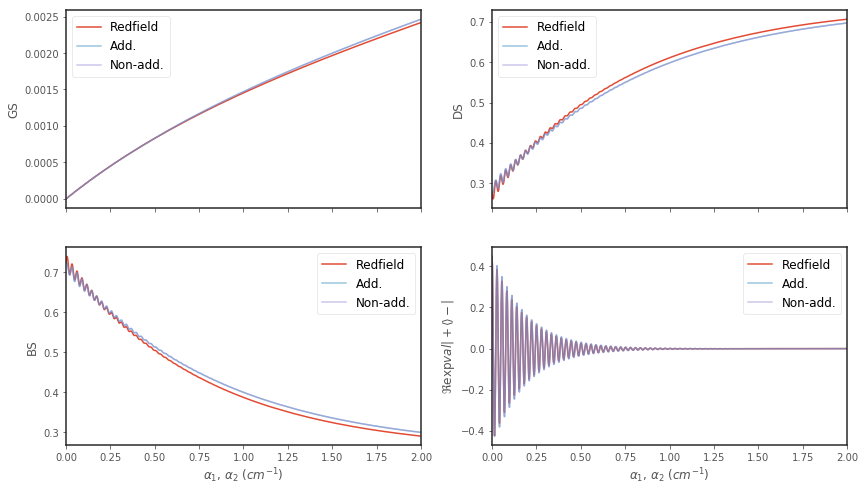

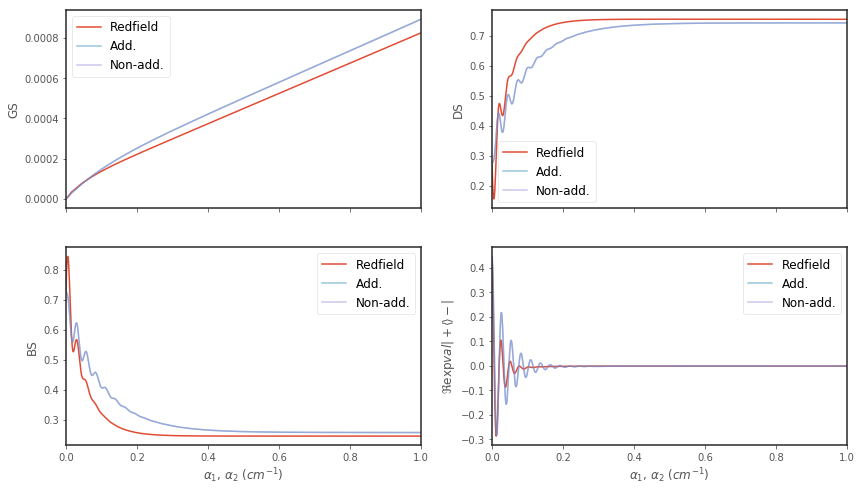

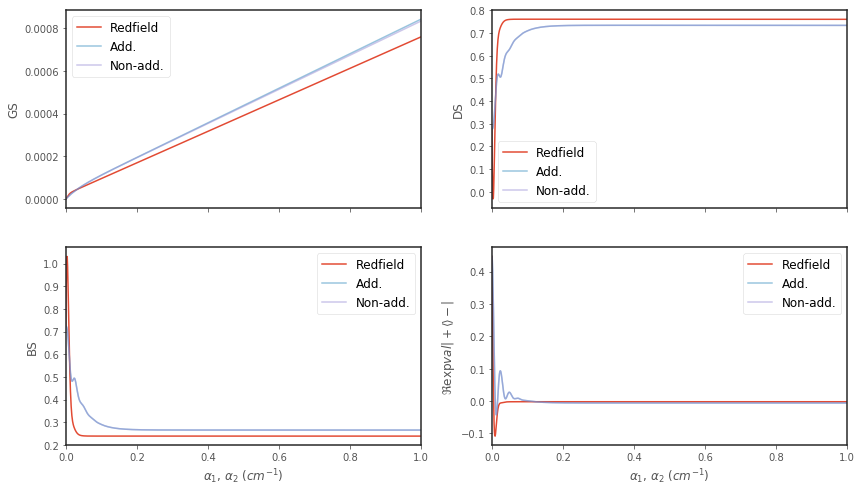

In [35]:
plot_dynamics(dynamics_5a)
plot_dynamics(dynamics_5b)
plot_dynamics(dynamics_5c)

In [ ]:
w_0 = 2000. # 
Gamma = (w_0**2)/53.
N=4
T_ph = 300.
"""PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=1.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5aa = get_dynamics_data(PARAMS, '5aa', threshold=0., tf=2)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=10.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5bb = get_dynamics_data(PARAMS, '5bb', threshold=1e-8, tf=1)
"""
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=50.,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
dynamics_5cc = get_dynamics_data(PARAMS, '5cc', threshold=1e-8, tf=0.25)

In [10]:
dynamics_5aa = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_5aa")
dynamics_5bb = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_5bb")
dynamics_5cc = load_obj("DATA/DYNAMICS_2019/3LS_dynamics_5cc")

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


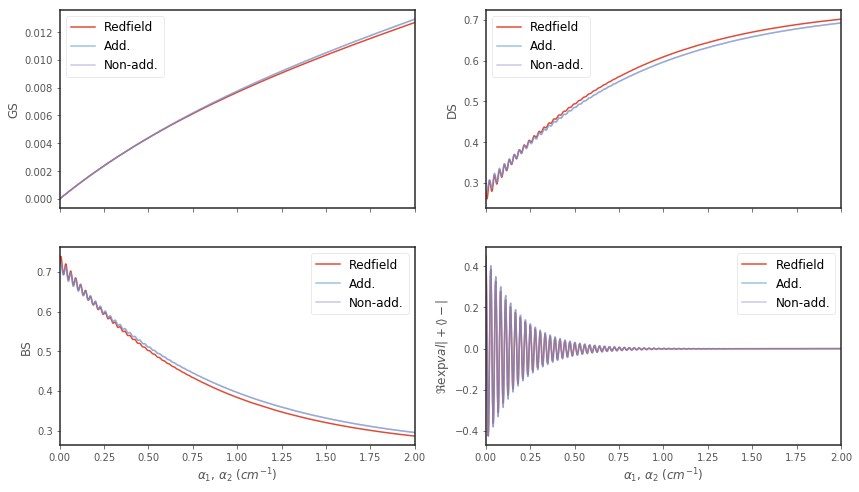

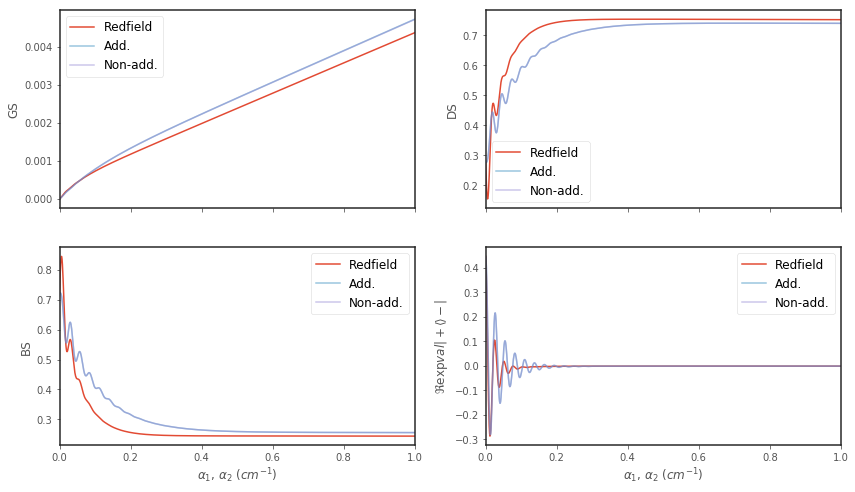

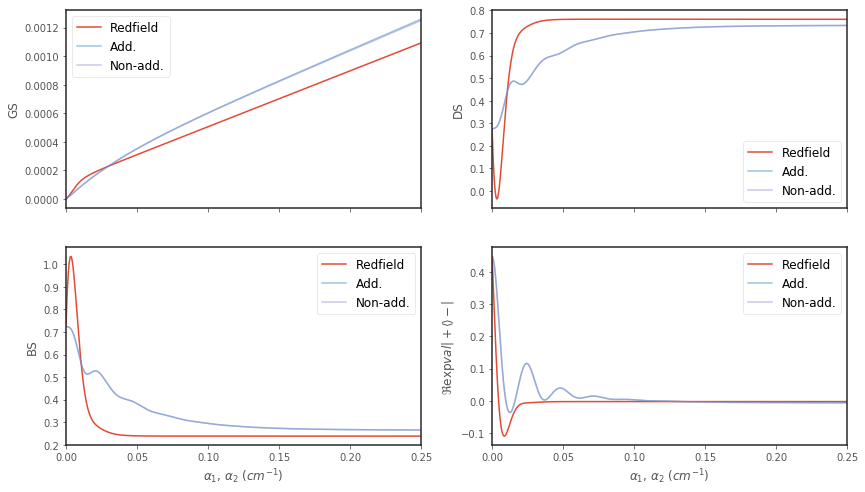

In [11]:
plot_dynamics(dynamics_5aa)
plot_dynamics(dynamics_5bb)
plot_dynamics(dynamics_5cc)

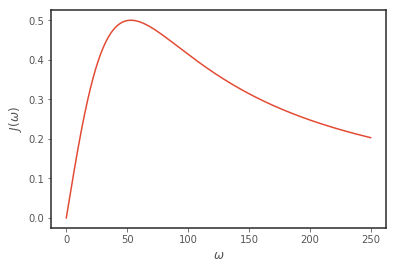

In [24]:
w_0 = 2000. # 
Gamma = (w_0**2)/53.
alpha=1.
plot_UD_SD(Gamma, alpha, w_0, eps=250., ax=None)